In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import json
import re
from datetime import datetime
from string import punctuation
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import torch.nn as nn
%matplotlib inline

In [9]:
raw_data_file_path = "./ratebeer.json"

In [92]:
# initial pass at fixing data
f = open(raw_data_file_path)
s = f.read()
s = s.replace('"', "'")
s = s.replace("\\", "")
s = re.sub(r"'([a-zA-Z0-9\/]+)':( ')", r'"\1":\2', s)
s = re.sub(r": '(.*?)'(, \"|})", r': "\1"\2', s)
s = s.replace("}", "},")
s = "[" + s + "]"

In [93]:
# edge cases
index1 = 1211756778
sus = 5
s = s[0:index1-sus] + "'" + s[index1-sus+1:]
index2 = 1211757555
sus = 3
s = s[0:index2-sus] + '"' + s[index2-sus+1:]
index3 = 1931627431
sus = 2
s = s[0:index3-sus] + s[index3-sus+1:]

In [90]:
data = json.loads(s)

In [91]:
# save as new json file
json_object = json.dumps(data, indent=4)
with open("./beer_data.json", "w") as outfile:
    outfile.write(json_object)

In [401]:
# read in fixed json file from now on
data_file_path = './beer_data.json'
df_full = pd.read_json(data_file_path)

In [404]:
def eval_expr(expr):
    try:
        return eval(expr)
    except:
        return -1

In [405]:
# build new columns with float values instead of string expressions
df_full['appearance'] = df_full.apply(lambda row : eval_expr(row['review/appearance']), axis=1)
df_full['aroma'] = df_full.apply(lambda row : eval_expr(row['review/aroma']), axis=1)
df_full['palate'] = df_full.apply(lambda row : eval_expr(row['review/palate']), axis=1)
df_full['taste'] = df_full.apply(lambda row : eval_expr(row['review/taste']), axis=1)
df_full['overall'] = df_full.apply(lambda row : eval_expr(row['review/overall']), axis=1)

In [409]:
df_full = df_full[(df_full['overall'] >= 0) & (df_full['beer/ABV'] != '-')]

In [560]:
df_full = df_full.reset_index(drop=True)

In [410]:
beer_names = df_full['beer/name'].unique()
beer_styles = df_full['beer/style'].unique()
beer_style_index = dict(zip(beer_styles, range(len(beer_styles))))

In [411]:
# build new abv column with float values instead of strings and also a beer style column with an index instead of string
df_full['abv'] = df_full.apply(lambda row: float(row['beer/ABV']), axis=1)
df_full['style'] = df_full.apply(lambda row: beer_style_index[row['beer/style']], axis=1)

/Users/maxyuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/maxyuan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [561]:
positive_rating = df_full[df_full['overall'] > 0.5]
negative_rating = df_full[df_full['overall'] <= 0.5]

high_rating = df_full[df_full['overall'] > 0.7]
med_rating = df_full[(df_full['overall'] >= 0.4) & (df_full['overall'] <= 0.7)]
low_rating = df_full[df_full['overall'] < 0.4]

In [562]:
print(len(positive_rating.index))
print(len(negative_rating.index))

print(len(high_rating.index))
print(len(med_rating.index))
print(len(low_rating.index))

2299884
485642
1100450
1501568
183508


In [582]:
# create dataset with equal number of the different kinds ratings
NUM_SAMPLES = 18000
NUM_SAMPLES_WITH_PADDING = NUM_SAMPLES + 300 # we remove empty reviews later so this allows space for that
positive_indices = random.sample(positive_rating.index.tolist(), int(NUM_SAMPLES_WITH_PADDING / 2))
negative_indices = random.sample(negative_rating.index.tolist(), int(NUM_SAMPLES_WITH_PADDING / 2))

high_indices = random.sample(high_rating.index.tolist(), int(NUM_SAMPLES_WITH_PADDING / 3))
med_indices = random.sample(med_rating.index.tolist(), int(NUM_SAMPLES_WITH_PADDING / 3))
low_indices = random.sample(low_rating.index.tolist(), int(NUM_SAMPLES_WITH_PADDING / 3))

In [754]:
# _b means binary rating, which is just positive or negative
# _t means ternary rating, which is high, medium, and low
rows_b = positive_indices + negative_indices
rows_t = high_indices + med_indices +low_indices

In [584]:
df_b = df_full.iloc[rows_b]
df_t = df_full.iloc[rows_t]

In [585]:
print(df_b.shape)
df_b.head()

(18300, 20)


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,appearance,aroma,palate,taste,overall,abv,style
1715141,Bells Oberon Ale,3211,232.0,6,Wheat Ale,5/5,7/10,4/5,8/10,15/20,1.038096e+09,Andrew196,Probably the best wheat beer I have had in a l...,1.0,0.7,0.8,0.8,0.75,6.0,21
672442,Ridgeway Foreign Export Stout,70803,1265.0,8,Foreign Stout,4/5,6/10,3/5,6/10,13/20,1.200874e+09,MesandSim,"UPDATED: AUG 28, 2008 A Mes rate: Bottle at my...",0.8,0.6,0.6,0.6,0.65,8.0,69
631026,Cigar City Extra Sour Guava Grove,136408,9990.0,8,Sour Ale/Wild Ale,3/5,7/10,3/5,8/10,15/20,1.324598e+09,sebletitje,Entering old rates. Bottle shared with Wayne @...,0.6,0.7,0.6,0.8,0.75,8.0,23
1537341,Victory Dark Intrigue,132106,101.0,9.1,Imperial Stout,4/5,7/10,4/5,7/10,15/20,1.303085e+09,Fin,"Bottle at Jan & Charlottes tasting, Ulfborg,...",0.8,0.7,0.8,0.7,0.75,9.1,13
1062334,Founders Double Trouble IPA,67360,554.0,9.4,Imperial/Double IPA,4/5,8/10,4/5,8/10,17/20,1.241309e+09,ApisAles,Really solid IPA. Had it on tap at RFD in D.C...,0.8,0.8,0.8,0.8,0.85,9.4,7


In [586]:
print(df_t.shape)
df_t.head()

(18300, 20)


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,appearance,aroma,palate,taste,overall,abv,style
1688104,Bells Java Stout,10338,232.0,7.5,Stout,4/5,9/10,5/5,8/10,15/20,1.214266e+09,lunchbox582,12 oz bought from the brewery in a mixed sixer...,0.8,0.9,1.0,0.8,0.75,7.5,16
330058,Pinkus Hefe Weizen,4552,742.0,5,German Hefeweizen,4/5,8/10,4/5,8/10,17/20,1.012349e+09,wheatbeerboy,A really different tasting hefeweizen. I could...,0.8,0.8,0.8,0.8,0.85,5.0,30
1792395,Leelanau Whaleback White,49308,4923.0,5.2,Belgian White &#40;Witbier&#41;,4/5,7/10,4/5,8/10,16/20,1.168992e+09,thebaldwizard,Shared at C-bus tasting 5. I wish all Wits ta...,0.8,0.7,0.8,0.8,0.80,5.2,36
1114182,Sierra Nevada Hoptimum,117825,67.0,10.4,Imperial/Double IPA,4/5,7/10,4/5,7/10,16/20,1.284422e+09,JohnnyJ,"Draft at the brewery. Golden amber pour, whit...",0.8,0.7,0.8,0.7,0.80,10.4,7
1008245,Samuel Adams Imperial Series Double Bock,96144,32.0,9.5,Doppelbock,3/5,7/10,3/5,7/10,16/20,1.236384e+09,emacgee,Pours a dark ruby copper with a thin light tan...,0.6,0.7,0.6,0.7,0.80,9.5,38


In [587]:
# remove punctuation from reviews
reviews_b = df_b['review/text'].values.tolist()
reviews_b = [review.translate(str.maketrans('','',punctuation)).lower() for review in reviews_b]

reviews_t = df_t['review/text'].values.tolist()
reviews_t = [review.translate(str.maketrans('','',punctuation)).lower() for review in reviews_t]

In [588]:
# create vocab from words in reviews

all_reviews_b = ' '.join(reviews_b)
words_b = all_reviews_b.split()
word_to_count_b = Counter(words_b)
words_sorted_b = word_to_count_b.most_common(len(words_b))
word_to_index_b = {word:index+1 for index, (word,count) in enumerate(words_sorted_b)}

all_reviews_t = ' '.join(reviews_t)
words_t = all_reviews_t.split()
word_to_count_t = Counter(words_t)
words_sorted_t = word_to_count_t.most_common(len(words_t))
word_to_index_t = {word:index+1 for index, (word,count) in enumerate(words_sorted_t)}

In [589]:
# tokenize reviews
reviews_tokenized_og_b = [[word_to_index_b[word] for word in review.split()] for review in reviews_b]
reviews_tokenized_og_t = [[word_to_index_t[word] for word in review.split()] for review in reviews_t]

In [592]:
# build labels
overall_ratings_b = df_b['overall'].values.tolist()
binary_labels_og = [1 if rating > 0.5 else 0 for rating in overall_ratings_b]

overall_ratings_t = df_t['overall'].values.tolist()
ternary_labels_og = [2 if rating > 0.7 else (0 if rating < 0.4 else 1) for rating in overall_ratings_t]

print([binary_labels_og.count(x) for x in range(2)])
print([ternary_labels_og.count(x) for x in range(3)])

[9150, 9150]
[6100, 6100, 6100]


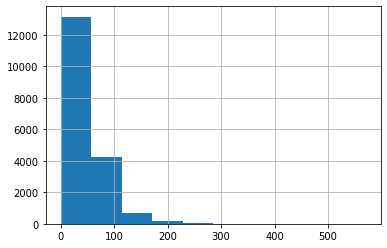

count    18300.000000
mean        49.345902
std         35.626908
min          0.000000
25%         27.000000
50%         40.000000
75%         60.000000
max        570.000000
dtype: float64

In [593]:
# see how long reviews are to determine sequence length for LSTM model

reviews_len_b = [len(x) for x in reviews_tokenized_og_b]
pd.Series(reviews_len_b).hist()
plt.show()
pd.Series(reviews_len_b).describe()

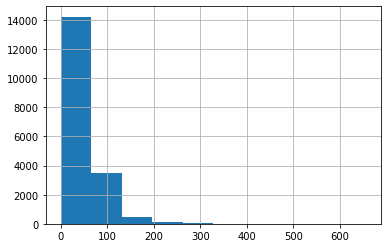

count    18300.000000
mean        50.530929
std         36.861034
min          0.000000
25%         28.000000
50%         41.000000
75%         62.000000
max        655.000000
dtype: float64

In [594]:
reviews_len_t = [len(x) for x in reviews_tokenized_og_t]
pd.Series(reviews_len_t).hist()
plt.show()
pd.Series(reviews_len_t).describe()

In [595]:
# remove reviews that are empty
reviews_tokenized_og_b = [reviews_tokenized_og_b[i] for i, length in enumerate(reviews_len_b) if length > 0]
reviews_tokenized_og_t = [reviews_tokenized_og_t[i] for i, length in enumerate(reviews_len_t) if length > 0]

binary_labels_og = [binary_labels_og[i] for i, length in enumerate(reviews_len_b) if length > 0]
ternary_labels_og = [ternary_labels_og[i] for i, length in enumerate(reviews_len_t) if length > 0]

In [596]:
def pad_tokens(reviews, seq_length):
    # pad beginning of tokens with 0 or truncate to seq_length
    features = np.zeros((len(reviews), seq_length), dtype = int)
    
    for index, tokens in enumerate(reviews):
        if len(tokens) != 0:
            features[index, -(min(seq_length, len(tokens))):] = np.array(tokens)[:min(seq_lenth, len(tokens))]
    
    return features

In [601]:
features_og_b = pad_tokens(reviews_tokenized_og_b, 200)
features_og_t = pad_tokens(reviews_tokenized_og_t, 200)

binary_labels_og=np.array(binary_labels_og)
ternary_labels_og=np.array(ternary_labels_og)

In [603]:
# cut back down to NUM_SAMPLES after removing empty reviews

num_features_og_b = len(features_og_b)
num_features_og_t = len(features_og_t)

random_subset_b = random.sample(range(num_features_og_b), NUM_SAMPLES)
random_subset_t = random.sample(range(num_features_og_t), NUM_SAMPLES)

features_b = features_og_b[random_subset_b,]
binary_labels = binary_labels_og[random_subset_b]

features_t = features_og_t[random_subset_t,]
ternary_labels = ternary_labels_og[random_subset_t]

print(features_b.shape)
print(features_t.shape)
print(binary_labels.shape)
print(ternary_labels.shape)

(18000, 200)
(18000, 200)
(18000,)
(18000,)


In [604]:
# how good is random guessing?

print(np.mean(binary_labels==random.choices(range(2), k=len(binary_labels))))
print(np.mean(ternary_labels==random.choices(range(3), k=len(ternary_labels))))

0.4976111111111111
0.3298333333333333


In [605]:
# build train, validate, and test sets

split_frac = 0.8
num_features = len(features_b)
train_x_b = features_b[0:int(split_frac*num_features)]
train_x_t = features_t[0:int(split_frac*num_features)]
train_y_b = binary_labels[0:int(split_frac*num_features)]
train_y_t = ternary_labels[0:int(split_frac*num_features)]

remaining_x_b = features_b[int(split_frac*num_features):]
remaining_x_t = features_t[int(split_frac*num_features):]
remaining_y_b = binary_labels[int(split_frac*num_features):]
remaining_y_t = ternary_labels[int(split_frac*num_features):]

valid_x_b = remaining_x_b[0:int(len(remaining_x_b)*0.5)]
valid_x_t = remaining_x_t[0:int(len(remaining_x_t)*0.5)]
valid_y_b = remaining_y_b[0:int(len(remaining_y_b)*0.5)]
valid_y_t = remaining_y_t[0:int(len(remaining_y_t)*0.5)]

test_x_b = remaining_x_b[int(len(remaining_x_b)*0.5):]
test_x_t = remaining_x_t[int(len(remaining_x_t)*0.5):]
test_y_b = remaining_y_b[int(len(remaining_y_b)*0.5):]
test_y_t = remaining_y_t[int(len(remaining_y_t)*0.5):]

In [606]:
class SentimentLSTM(nn.Module):
    # LSTM for sentiment analysis

    def __init__(
        self,
        vocab_size,
        output_size,
        embedding_dim,
        hidden_dim,
    ):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, 2, dropout=0.5, batch_first=True
        )

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # fully connected linear layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        # sigmoid layer for the binary sentiment analysis case
        self.sig = nn.Sigmoid()
        
        # softmax layer for the ternary sentiment analysis case
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid or softmax function
        prob_out = self.sig(out) if self.output_size == 1 else self.softmax(out)

        # reshape to be batch_size as first dimension
        if self.output_size == 1:
            prob_out = prob_out.view(batch_size, -1)
            prob_out = prob_out[:, -1]  # get last batch of labels
        else:
            prob_out = prob_out.view(batch_size, -1, self.output_size)
            prob_out = prob_out[:, -1, :] # get last batch of labels
        

        # return last sigmoid/softmax output and hidden state
        return prob_out, hidden

    def init_hidden(self, batch_size):
        # create 2 tensors with sizes 2 x batch_size x hidden_dim,
        weight = next(self.parameters()).data

        # initialized hidden state to 0
        hidden = (
            weight.new(2, batch_size, self.hidden_dim).zero_(),
            weight.new(2, batch_size, self.hidden_dim).zero_(),
        )

        return hidden


In [607]:
batch_size = 50
# create datasets
train_data_b = TensorDataset(torch.from_numpy(train_x_b), torch.from_numpy(train_y_b))
valid_data_b = TensorDataset(torch.from_numpy(valid_x_b), torch.from_numpy(valid_y_b))
test_data_b = TensorDataset(torch.from_numpy(test_x_b), torch.from_numpy(test_y_b))

train_data_t = TensorDataset(torch.from_numpy(train_x_t), torch.from_numpy(train_y_t))
valid_data_t = TensorDataset(torch.from_numpy(valid_x_t), torch.from_numpy(valid_y_t))
test_data_t = TensorDataset(torch.from_numpy(test_x_t), torch.from_numpy(test_y_t))

# dataloaders
train_loader_b = DataLoader(train_data_b, shuffle=True, batch_size=batch_size)
valid_loader_b = DataLoader(valid_data_b, shuffle=True, batch_size=batch_size)
test_loader_b = DataLoader(test_data_b, shuffle=True, batch_size=batch_size)

train_loader_t = DataLoader(train_data_t, shuffle=True, batch_size=batch_size)
valid_loader_t = DataLoader(valid_data_t, shuffle=True, batch_size=batch_size)
test_loader_t = DataLoader(test_data_t, shuffle=True, batch_size=batch_size)

In [619]:
# Create the two models
vocab_size_b = len(word_to_index_b)+1
vocab_size_t = len(word_to_index_t)+1
output_size_b = 1
output_size_t = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net_b = SentimentLSTM(vocab_size_b, output_size_b, embedding_dim, hidden_dim)
net_t = SentimentLSTM(vocab_size_t, output_size_t, embedding_dim, hidden_dim)
print(net_b)
print(net_t)

SentimentLSTM(
  (embedding): Embedding(36592, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
  (softmax): Softmax(dim=1)
)
SentimentLSTM(
  (embedding): Embedding(37244, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (sig): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [620]:
# TRAINING FOR BINARY SENTIMENT ANALYSIS

# loss and optimization functions
lr=1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net_b.parameters(), lr=lr)

# training params
epochs = 4
counter = 0
print_every = 50
clip=5 # gradient clipping
epoch_accuracies = []

net_b.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net_b.init_hidden(batch_size)
    
    epoch_correct = 0
    epoch_total = 0

    # batch loop
    for inputs, labels in train_loader_b:
        counter += 1
        # copy hidden state
        h = tuple([each.data for each in h])

        # zero gradients
        net_b.zero_grad()

        # get predicted output
        inputs = inputs.type(torch.LongTensor)
        output, h = net_b(inputs, h)
        
        # calculate accuracy for this step
        preds = torch.round(output.squeeze())
        mask = preds[preds == labels]
        train_correct = len(mask)
        train_total = len(labels)
        
        epoch_correct += train_correct
        epoch_total += train_total

        # calculate loss and backprop
        loss = loss_fn(output.squeeze(), labels.float())
        loss.backward()

        # prevent exploding gradient problem in LSTMs.
        nn.utils.clip_grad_norm_(net_b.parameters(), clip)
        optimizer.step()

        # print stats
        if counter % print_every == 0:
            val_h = net_b.init_hidden(batch_size)
            val_losses = []
            net_b.eval()
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader_b:
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net_b(inputs, val_h)
                
                preds = torch.round(output.squeeze())
                mask = preds[preds == labels]
                val_correct += len(mask)
                val_total += len(labels)
                
                val_loss = loss_fn(output.squeeze(), labels.float())
                val_losses.append(val_loss.item())

            net_b.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Accuracy: {:.6f}...".format(float(train_correct)/train_total),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Accuracy: {:.6f}...".format(float(val_correct) / val_total),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

    epoch_accuracies.append(float(epoch_correct) / epoch_total)

Epoch: 1/4... Step: 50... Accuracy: 0.700000... Loss: 0.597491... Val Accuracy: 0.707000... Val Loss: 0.570098
Epoch: 1/4... Step: 100... Accuracy: 0.600000... Loss: 0.647017... Val Accuracy: 0.714600... Val Loss: 0.560543
Epoch: 1/4... Step: 150... Accuracy: 0.820000... Loss: 0.478556... Val Accuracy: 0.739200... Val Loss: 0.532575
Epoch: 2/4... Step: 200... Accuracy: 0.840000... Loss: 0.373601... Val Accuracy: 0.754800... Val Loss: 0.506916
Epoch: 2/4... Step: 250... Accuracy: 0.900000... Loss: 0.342841... Val Accuracy: 0.773600... Val Loss: 0.486545
Epoch: 2/4... Step: 300... Accuracy: 0.780000... Loss: 0.371110... Val Accuracy: 0.783400... Val Loss: 0.485738
Epoch: 3/4... Step: 350... Accuracy: 0.920000... Loss: 0.246705... Val Accuracy: 0.778400... Val Loss: 0.504856
Epoch: 3/4... Step: 400... Accuracy: 0.820000... Loss: 0.370458... Val Accuracy: 0.769200... Val Loss: 0.487841
Epoch: 3/4... Step: 450... Accuracy: 0.820000... Loss: 0.399457... Val Accuracy: 0.773600... Val Loss: 0.

In [621]:
for i in range(len(epoch_accuracies)):
    print("Epoch #{} Accuracy: {:.3f}%".format(i + 1, epoch_accuracies[i] * 100))

Epoch #1 Accuracy: 68.150%
Epoch #2 Accuracy: 79.350%
Epoch #3 Accuracy: 85.112%
Epoch #4 Accuracy: 90.438%


In [622]:
# test model
num_correct = 0

# init hidden state
h = net_b.init_hidden(batch_size)

net_b.eval()
# iterate over test data
for inputs, labels in test_loader_b:
    h = tuple([each.data for each in h])

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net_b(inputs, h)

    # get predicted class from output probabilities
    preds = torch.round(output.squeeze())
    mask = preds[preds == labels]
    num_correct += len(mask)

# test accuracy
print("Test accuracy: {:.3f}".format(float(num_correct)/len(test_loader_b.dataset)))

Test accuracy: 0.765


In [641]:
# TRAINING FOR TERNARY SENTIMENT ANALYSIS

# loss and optimization functions
lr=1e-3
# loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_t.parameters(), lr=lr)

# training params
epochs = 4
counter = 0
print_every = 50
clip=5 # gradient clipping
epoch_accuracies = []

net_t.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net_t.init_hidden(batch_size)
    
    epoch_correct = 0
    epoch_total = 0

    # batch loop
    for inputs, labels in train_loader_t:
        counter += 1
        # copy hidden state
        h = tuple([each.data for each in h])

        # zero gradients
        net_t.zero_grad()

        # get predicted output
        inputs = inputs.type(torch.LongTensor)
        output, h = net_t(inputs, h)
        preds = torch.argmax(output, dim=1)
        
        # calculate accuracy for this step
        preds = torch.argmax(output, dim=1)
        mask = preds[preds == labels]
        train_correct = len(mask)
        train_total = len(labels)
        
        epoch_correct += train_correct
        epoch_total += train_total

        # calculate loss and backprop
        loss = loss_fn(output, labels)
        loss.backward()

        # prevent exploding gradient problem in LSTMs.
        nn.utils.clip_grad_norm_(net_t.parameters(), clip)
        optimizer.step()

        # print stats
        if counter % print_every == 0:
            val_h = net_t.init_hidden(batch_size)
            val_losses = []
            net_t.eval()
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader_t:
                val_h = tuple([each.data for each in val_h])

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net_t(inputs, val_h)
                
                preds = torch.argmax(output, dim=1)
                mask = preds[preds == labels]
                val_correct += len(mask)
                val_total += len(labels)
                
                val_loss = loss_fn(output, labels)
                val_losses.append(val_loss.item())

            net_t.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Accuracy: {:.6f}...".format(float(train_correct)/train_total),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Accuracy: {:.6f}...".format(float(val_correct) / val_total),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

    epoch_accuracies.append(float(epoch_correct) / epoch_total)

Epoch: 1/4... Step: 50... Accuracy: 0.520000... Loss: 0.974587... Val Accuracy: 0.519600... Val Loss: 0.995337
Epoch: 1/4... Step: 100... Accuracy: 0.380000... Loss: 1.142842... Val Accuracy: 0.487800... Val Loss: 1.039565
Epoch: 1/4... Step: 150... Accuracy: 0.580000... Loss: 0.963992... Val Accuracy: 0.579600... Val Loss: 0.958414
Epoch: 2/4... Step: 200... Accuracy: 0.460000... Loss: 1.053802... Val Accuracy: 0.573200... Val Loss: 0.963046
Epoch: 2/4... Step: 250... Accuracy: 0.640000... Loss: 0.899877... Val Accuracy: 0.594600... Val Loss: 0.934599
Epoch: 2/4... Step: 300... Accuracy: 0.580000... Loss: 0.951416... Val Accuracy: 0.567200... Val Loss: 0.962075
Epoch: 3/4... Step: 350... Accuracy: 0.680000... Loss: 0.867643... Val Accuracy: 0.623200... Val Loss: 0.911001
Epoch: 3/4... Step: 400... Accuracy: 0.600000... Loss: 0.946137... Val Accuracy: 0.620600... Val Loss: 0.912677
Epoch: 3/4... Step: 450... Accuracy: 0.700000... Loss: 0.866722... Val Accuracy: 0.584200... Val Loss: 0.

In [642]:
for i in range(len(epoch_accuracies)):
    print("Epoch #{} Accuracy: {:.3f}%".format(i + 1, epoch_accuracies[i] * 100))

Epoch #1 Accuracy: 50.825%
Epoch #2 Accuracy: 61.113%
Epoch #3 Accuracy: 66.663%
Epoch #4 Accuracy: 70.837%


In [643]:
# test model
num_correct = 0

# init hidden state
h = net_t.init_hidden(batch_size)

net_t.eval()
# iterate over test data
for inputs, labels in test_loader_t:
    h = tuple([each.data for each in h])

    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net_t(inputs, h)

    # get predicted class from output probabilities
    preds = torch.argmax(output, dim=1)
    mask = preds[preds == labels]
    num_correct += len(mask)

# test accuracy
print("Test accuracy: {:.3f}".format(float(num_correct)/len(test_loader_b.dataset)))

Test accuracy: 0.623


In [647]:
abvs = df_full['abv'].values.tolist()
styles = df_full['style'].values.tolist()
ratings = df_full['overall'].values.tolist()
taste_ratings = df_full['taste'].values.tolist()
times = df_full['review/time'].values.tolist()
reviewers = df_full['review/profileName'].values.tolist()

In [649]:
reviewers_unique = df_full['review/profileName'].unique()

In [650]:
min_times = {}
max_times = {}

for i in range(len(times)):
    name = reviewers[i]
    time = times[i]
    if not name in min_times:
        min_times[name] = time
    if not name in max_times:
        max_times[name] = time
    min_times[name] = min(time, min_times[name])
    max_times[name] = max(time, max_times[name])

In [652]:
df_full['experience'] = df_full.apply(lambda row : (row['review/time'] - min_times[row['review/profileName']]) / (60*60*24), axis=1)

In [653]:
experiences = df_full['experience'].values.tolist()

In [656]:
beer_brewers = df_full['beer/brewerId'].unique()
beer_brewers_index = dict(zip(beer_brewers, range(len(beer_brewers))))
df_full['brewer'] = df_full.apply(lambda row: beer_brewers_index[row['beer/brewerId']], axis=1)
df_full.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,...,review/text,appearance,aroma,palate,taste,overall,abv,style,brewer,experience
0,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,3/5,6/10,13/20,...,"On tap at the Springfield, PA location. Poured...",0.8,0.6,0.6,0.6,0.65,5.4,0,0,854.0
1,John Harvards Simcoe IPA,63836,8481.0,5.4,India Pale Ale &#40;IPA&#41;,4/5,6/10,4/5,7/10,13/20,...,On tap at the John Harvards in Springfield PA....,0.8,0.6,0.8,0.7,0.65,5.4,0,0,499.0
2,John Harvards Cristal Pilsner,71716,8481.0,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,...,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne...",0.8,0.5,0.6,0.6,0.70,5.0,1,0,23.0
3,John Harvards Fancy Lawnmower Beer,64125,8481.0,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,...,On tap the Springfield PA location billed as t...,0.4,0.4,0.4,0.4,0.40,5.4,2,0,503.0
4,John Harvards Fancy Lawnmower Beer,64125,8481.0,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,...,"On tap at the Springfield, PA location. Poured...",0.4,0.4,0.4,0.4,0.40,5.4,2,0,854.0


In [657]:
breweries = df_full['brewer'].values.tolist()

In [723]:
class FeedForwardNet(nn.Module):
    # feed forward network to predict rating from variables like abv, beer style, brewery, and experience
    def __init__(
        self,
        input_size,
        output_size
    ): # initialize the model
        super().__init__()
        self.linear1 = nn.Linear(input_size,10)
        self.linear2 = nn.Linear(10,50)
        self.linear3 = nn.Linear(50,10)
        self.linear4 = nn.Linear(10,output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.softmax(self.linear4(x))
        return x

In [734]:
# build dataset with equal amounts of high, med, and low ratings

NUM_SAMPLES = 24000
high_indices = random.sample(high_rating.index.tolist(), int(NUM_SAMPLES / 3))
med_indices = random.sample(med_rating.index.tolist(), int(NUM_SAMPLES / 3))
low_indices = random.sample(low_rating.index.tolist(), int(NUM_SAMPLES / 3))

indices = high_indices + med_indices + low_indices
random.shuffle(indices)

df = df_full.iloc[indices]

In [735]:
df.head()
print(len(df))

24000


In [736]:
features = df[['brewer', 'abv', 'style']].to_numpy()
features_exp = df[['brewer', 'abv', 'style', 'experience']].to_numpy()

overall_ratings = df['overall'].values.tolist()
ternary_labels = np.array([2 if rating > 0.7 else (0 if rating < 0.4 else 1) for rating in overall_ratings])
print([np.count_nonzero(ternary_labels == x) for x in range(3)])

[8000, 8000, 8000]


In [737]:
# build train, validate, and test sets

split_frac = 0.8
num_features = len(features)
train_x = features[0:int(split_frac*num_features)]
train_x_exp = features_exp[0:int(split_frac*num_features)]
train_y = ternary_labels[0:int(split_frac*num_features)]

remaining_x = features[int(split_frac*num_features):]
remaining_x_exp = features_exp[int(split_frac*num_features):]
remaining_y = ternary_labels[int(split_frac*num_features):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_x_exp = remaining_x_exp[0:int(len(remaining_x_exp)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_x_exp = remaining_x_exp[int(len(remaining_x_exp)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [738]:
batch_size = 100
# create datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_data_exp = TensorDataset(torch.from_numpy(train_x_exp), torch.from_numpy(train_y))
valid_data_exp = TensorDataset(torch.from_numpy(valid_x_exp), torch.from_numpy(valid_y))
test_data_exp = TensorDataset(torch.from_numpy(test_x_exp), torch.from_numpy(test_y))

# dataloaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

train_loader_exp = DataLoader(train_data_exp, shuffle=True, batch_size=batch_size)
valid_loader_exp = DataLoader(valid_data_exp, shuffle=True, batch_size=batch_size)
test_loader_exp = DataLoader(test_data_exp, shuffle=True, batch_size=batch_size)

In [740]:
# Specify model params
input_size = len(features[0])
input_size_exp = len(features_exp[0])
output_size = 3

In [743]:
# function to train neural net
def train_net(net, train_loader, valid_loader):
    print(net)
    # loss and optimization functions
    lr=1e-3
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # training params
    epochs = 1000
    print_every = 100
    epoch_accuracies = []

    net.train()
    # train for some number of epochs
    for e in range(epochs):
        epoch_correct = 0
        epoch_total = 0

        # batch loop
        for inputs, labels in train_loader:
            inputs = inputs.type(torch.FloatTensor)
            output = net(inputs) # Get prediction probabilities from model

            # Calculate the loss
            loss = loss_fn(output,labels)
            loss.backward()

            # update epoch accuracy
            preds = torch.argmax(output, dim=1)
            mask = preds[preds == labels]
            train_correct = len(mask)
            train_total = len(labels)

            epoch_correct += train_correct
            epoch_total += train_total

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()

        # print stats
        if (e+1) % print_every == 0:
            val_losses = []
            net.eval()
            val_correct = 0
            val_total = 0
            for inputs, labels in valid_loader:
                inputs = inputs.type(torch.FloatTensor)
                output = net(inputs)

                val_loss = loss_fn(output, labels)
                val_losses.append(val_loss.item())

                preds = torch.argmax(output, dim=1)
                mask = preds[preds == labels]
                val_correct += len(mask)
                val_total += len(labels)

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Accuracy: {:.6f}...".format(float(epoch_correct)/epoch_total),
                  "Val Accuracy: {:.6f}...".format(float(val_correct) / val_total),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

        epoch_accuracies.append(float(epoch_correct) / epoch_total)
    for i in range(len(epoch_accuracies)):
        if (i%50 == 0):
            print("Epoch #{} Accuracy: {:.3f}%".format(i + 1, epoch_accuracies[i] * 100))

In [748]:
# function to test neural net
def test_net(net, test_loader):
    # test model
    num_correct = 0

    net.eval()
    # iterate over test data
    for inputs, labels in test_loader:
        # get predicted outputs
        inputs = inputs.type(torch.FloatTensor)
        output = net(inputs)

        # get predicted class from output probabilities
        preds = torch.argmax(output, dim=1)
        mask = preds[preds == labels]
        num_correct += len(mask)

    # test accuracy
    print("Test accuracy: {:.3f}".format(float(num_correct)/len(test_loader.dataset)))

In [744]:
# train network that doesn't use user experience

net = FeedForwardNet(input_size, output_size)
train_net(net, train_loader, valid_loader)

FeedForwardNet(
  (linear1): Linear(in_features=3, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (linear4): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Epoch: 100/1000... Accuracy: 0.335208... Val Accuracy: 0.322917... Val Loss: 1.098989
Epoch: 200/1000... Accuracy: 0.333073... Val Accuracy: 0.329583... Val Loss: 1.098897
Epoch: 300/1000... Accuracy: 0.338802... Val Accuracy: 0.350417... Val Loss: 1.098583
Epoch: 400/1000... Accuracy: 0.531823... Val Accuracy: 0.534583... Val Loss: 0.991501
Epoch: 500/1000... Accuracy: 0.540573... Val Accuracy: 0.501250... Val Loss: 1.007564
Epoch: 600/1000... Accuracy: 0.545521... Val Accuracy: 0.557500... Val Loss: 0.978145
Epoch: 700/1000... Accuracy: 0.559688... Val Accuracy: 0.545833... Val Loss: 0.976331
Epoch: 800/1000... Accuracy: 0.571146... Val Accuracy: 0.551667... Val Loss: 0.96

In [750]:
# test
test_net(net, test_loader)

Test accuracy: 0.578


In [751]:
# train network that does use user experience
net_exp = FeedForwardNet(input_size_exp, output_size)
train_net(net_exp, train_loader_exp, valid_loader_exp)

FeedForwardNet(
  (linear1): Linear(in_features=4, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=10, bias=True)
  (linear4): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Epoch: 100/1000... Accuracy: 0.336458... Val Accuracy: 0.324583... Val Loss: 1.226875
Epoch: 200/1000... Accuracy: 0.527969... Val Accuracy: 0.522500... Val Loss: 0.995432
Epoch: 300/1000... Accuracy: 0.575833... Val Accuracy: 0.560833... Val Loss: 0.979235
Epoch: 400/1000... Accuracy: 0.575052... Val Accuracy: 0.560000... Val Loss: 0.971382
Epoch: 500/1000... Accuracy: 0.594740... Val Accuracy: 0.585833... Val Loss: 0.941567
Epoch: 600/1000... Accuracy: 0.592812... Val Accuracy: 0.583750... Val Loss: 0.948661
Epoch: 700/1000... Accuracy: 0.598958... Val Accuracy: 0.577500... Val Loss: 0.944894
Epoch: 800/1000... Accuracy: 0.604167... Val Accuracy: 0.587917... Val Loss: 0.94

In [752]:
# test
test_net(net_exp, test_loader_exp)

Test accuracy: 0.583
